# BERT4Rec Product Recommendation Model

This notebook tests the BERT4Rec implementation on the H&M dataset.

## Overview

- Load preprocessed H&M datasets from `data/modelling_data/`
- Prepare customer purchase sequences
- Train BERT4Rec model with masked language modeling
- Evaluate next-item prediction performance

## Dataset Files

- `transactions_final.parquet`: Clean transaction data
- `segmented_customers.parquet`: Customer features with cluster segments
- `articles_features_final.parquet`: Product features and attributes


## 1. Setup and Imports


In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('../../')

import polars as pl
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import time
from datetime import datetime

# Import BERT4Rec implementation
from hnm_data_analysis.data_modelling.bert4rec_modelling import (
    SequenceOptions, prepare_sequences_with_polars,
    build_dataloaders_for_bert4rec, BERT4RecModel, TrainConfig,
    train_bert4rec, evaluate_next_item_topk, set_all_seeds,
    MaskingOptions
)

# Set paths
DATA_ROOT = Path('../../data/modelling_data')
RESULTS_ROOT = Path('../../results/modelling')
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

# Set seeds for reproducibility
set_all_seeds(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Setup complete!")

Using device: cpu
✅ Setup complete!


## 2. Load and Explore Data


In [2]:
# Load datasets
print("📁 Loading datasets...")

# Load transactions
transactions = pl.read_parquet(DATA_ROOT / 'transactions_final.parquet')
print(f"Transactions shape: {transactions.shape}")
print(f"Columns: {transactions.columns}")
print(f"Date range: {transactions['t_dat'].min()} to {transactions['t_dat'].max()}")

# Load customer features
customers = pl.read_parquet(DATA_ROOT / 'segmented_customers.parquet')
print(f"\nCustomers shape: {customers.shape}")
print(f"Customer segments: {customers['customer_cluster'].unique().sort()}")

# Load article features  
articles = pl.read_parquet(DATA_ROOT / 'articles_features_final.parquet')
print(f"\nArticles shape: {articles.shape}")
print(f"Product groups: {articles['product_group_name'].n_unique()}")
print(f"BERT clusters: {articles['bert_cluster'].n_unique()} (with nulls: {articles['bert_cluster'].null_count()})")

print("\n✅ Data loaded successfully!")

📁 Loading datasets...
Transactions shape: (3904391, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']
Date range: 2020-06-24 to 2020-09-22

Customers shape: (525075, 15)
Customer segments: shape: (5,)
Series: 'customer_cluster' [i32]
[
	0
	1
	2
	3
	4
]

Articles shape: (42298, 14)
Product groups: 18
BERT clusters: 33 (with nulls: 69)

✅ Data loaded successfully!


## 3. Data Analysis and Preprocessing


In [3]:
# Analyze transaction patterns
print("🔍 Analyzing transaction patterns...")

# Unique counts
n_customers = transactions['customer_id'].n_unique()
n_articles = transactions['article_id'].n_unique() 
n_transactions = len(transactions)

print(f"Unique customers: {n_customers:,}")
print(f"Unique articles: {n_articles:,}")
print(f"Total transactions: {n_transactions:,}")
print(f"Sparsity: {(1 - n_transactions / (n_customers * n_articles)) * 100:.2f}%")

# Purchase frequency analysis
customer_txn_counts = transactions.group_by('customer_id').agg(
    pl.count().alias('transaction_count'),
    pl.col('article_id').n_unique().alias('unique_articles')
)

print(f"\nCustomer transaction statistics:")
print(customer_txn_counts['transaction_count'].describe())

# Filter customers with minimum transactions for meaningful sequences
min_transactions = 5
active_customers = customer_txn_counts.filter(
    pl.col('transaction_count') >= min_transactions
)['customer_id'].to_list()

print(f"\nCustomers with ≥{min_transactions} transactions: {len(active_customers):,} ({len(active_customers)/n_customers*100:.1f}%)")

# Filter transactions to active customers only
filtered_transactions = transactions.filter(
    pl.col('customer_id').is_in(active_customers)
)

print(f"Filtered transactions: {len(filtered_transactions):,} ({len(filtered_transactions)/n_transactions*100:.1f}%)")

🔍 Analyzing transaction patterns...
Unique customers: 525,075
Unique articles: 42,298
Total transactions: 3,904,391
Sparsity: 99.98%

Customer transaction statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 525075.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 7.435873 │
│ std        ┆ 9.059144 │
│ min        ┆ 1.0      │
│ 25%        ┆ 2.0      │
│ 50%        ┆ 5.0      │
│ 75%        ┆ 9.0      │
│ max        ┆ 350.0    │
└────────────┴──────────┘

Customers with ≥5 transactions: 268,057 (51.1%)
Filtered transactions: 3,296,379 (84.4%)


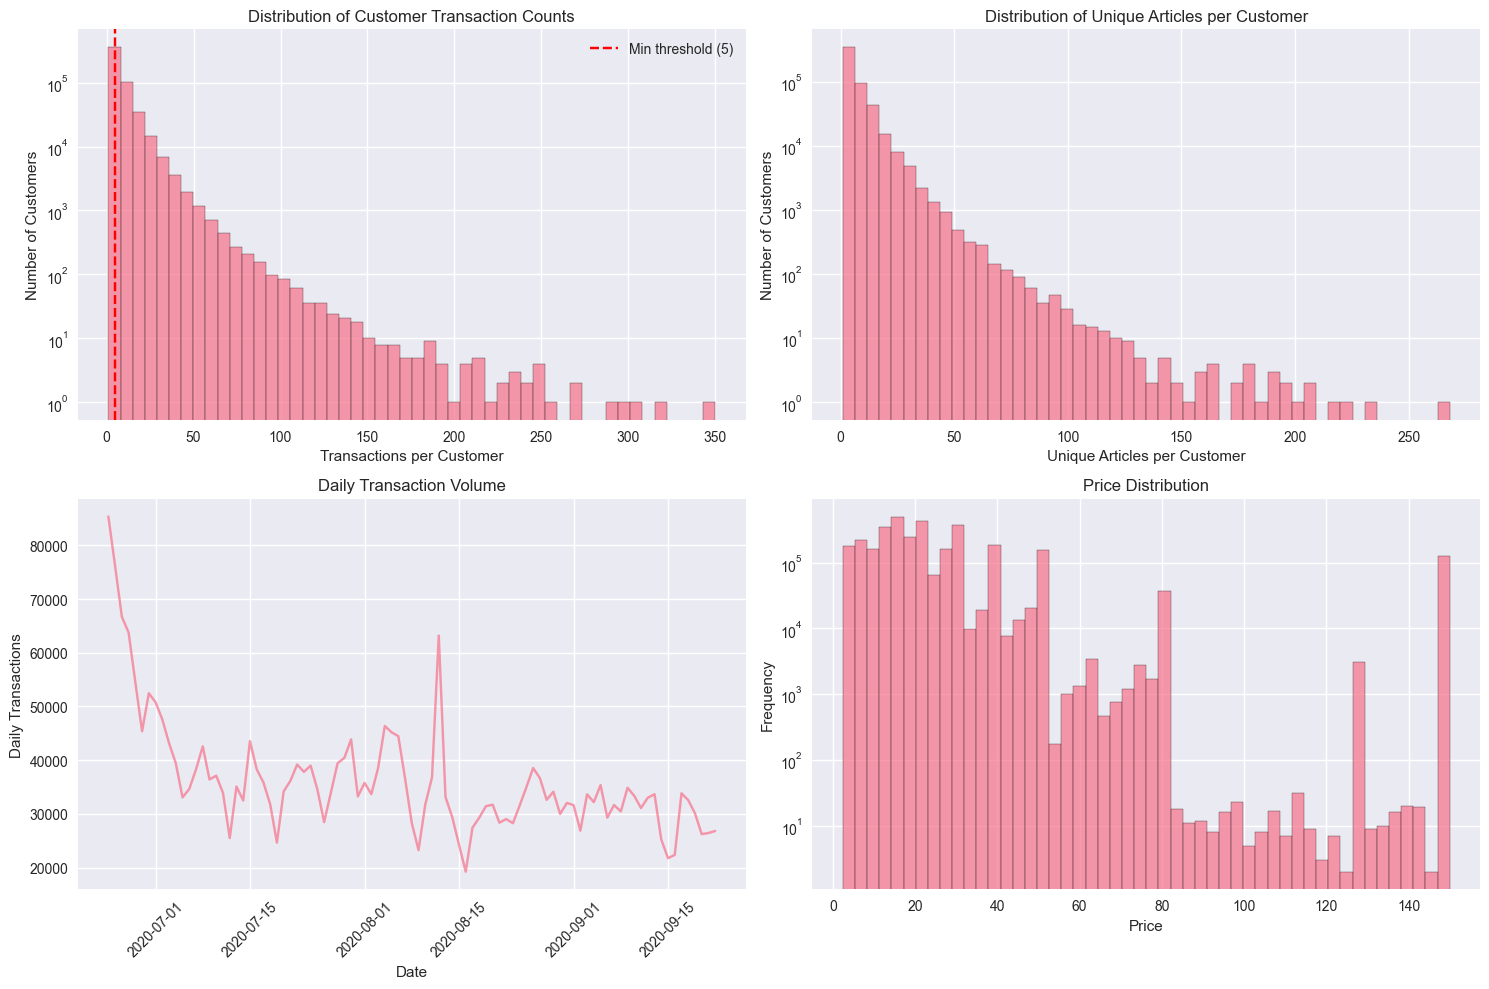

📊 Transaction analysis complete!


In [4]:
# Visualize transaction patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction count distribution
txn_counts = customer_txn_counts['transaction_count'].to_numpy()
axes[0,0].hist(txn_counts, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(min_transactions, color='red', linestyle='--', label=f'Min threshold ({min_transactions})')
axes[0,0].set_xlabel('Transactions per Customer')
axes[0,0].set_ylabel('Number of Customers')
axes[0,0].set_title('Distribution of Customer Transaction Counts')
axes[0,0].legend()
axes[0,0].set_yscale('log')

# Unique articles per customer
unique_articles = customer_txn_counts['unique_articles'].to_numpy()
axes[0,1].hist(unique_articles, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Unique Articles per Customer')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].set_title('Distribution of Unique Articles per Customer')
axes[0,1].set_yscale('log')

# Daily transaction volume
daily_txns = filtered_transactions.group_by('t_dat').agg(
    pl.count().alias('daily_transactions')
).sort('t_dat')

dates = daily_txns['t_dat'].to_list()
volumes = daily_txns['daily_transactions'].to_list()

axes[1,0].plot(dates, volumes, alpha=0.7)
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Daily Transactions')
axes[1,0].set_title('Daily Transaction Volume')
axes[1,0].tick_params(axis='x', rotation=45)

# Price distribution
prices = filtered_transactions['price'].to_numpy()
axes[1,1].hist(prices, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Price')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Price Distribution')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'transaction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Transaction analysis complete!")

## 4. Prepare Sequences for BERT4Rec


In [5]:
# Prepare customer segments for prefix tokens
user_segments = customers.select(['customer_id', 'customer_cluster'])

print("🔄 Preparing sequences for BERT4Rec...")

# Configuration for sequence preparation
sequence_options = SequenceOptions(
    max_len=50,                    # Maximum sequence length
    min_len=3,                     # Minimum sequence length
    deduplicate_exact=True,        # Remove exact duplicate transactions
    treat_same_day_as_basket=True, # Order same-day items by article_id
    add_segment_prefix=True,       # Add customer cluster as prefix
    add_channel_prefix=True,       # Add sales channel as prefix
    add_priceband_prefix=True,     # Add price band as prefix
    n_price_bins=10               # Number of price bins
)

print(f"Sequence options:")
print(f"  Max length: {sequence_options.max_len}")
print(f"  Min length: {sequence_options.min_len}")
print(f"  Use prefixes: segment={sequence_options.add_segment_prefix}, channel={sequence_options.add_channel_prefix}, price={sequence_options.add_priceband_prefix}")

# Prepare sequences
start_time = time.time()
prepared_data = prepare_sequences_with_polars(
    transactions=filtered_transactions,
    user_segments=user_segments,
    options=sequence_options
)
prep_time = time.time() - start_time

print(f"\n✅ Sequence preparation complete in {prep_time:.2f} seconds!")
print(f"Number of sequences: {len(prepared_data.sequences):,}")
print(f"Vocabulary size: {prepared_data.registry.vocab_size:,}")
print(f"Average sequence length: {np.mean([len(seq) for seq in prepared_data.sequences]):.1f}")
print(f"Average prefix length: {np.mean(prepared_data.prefix_lengths):.1f}")

# Analyze sequence lengths
seq_lengths = [len(seq) for seq in prepared_data.sequences]
print(f"\nSequence length statistics:")
print(f"  Min: {min(seq_lengths)}")
print(f"  Max: {max(seq_lengths)}")
print(f"  Median: {np.median(seq_lengths):.1f}")
print(f"  95th percentile: {np.percentile(seq_lengths, 95):.1f}")

🔄 Preparing sequences for BERT4Rec...
Sequence options:
  Max length: 50
  Min length: 3
  Use prefixes: segment=True, channel=True, price=True

✅ Sequence preparation complete in 17.68 seconds!
Number of sequences: 267,027
Vocabulary size: 41,090
Average sequence length: 14.0
Average prefix length: 3.0

Sequence length statistics:
  Min: 6
  Max: 50
  Median: 11.0
  95th percentile: 30.0


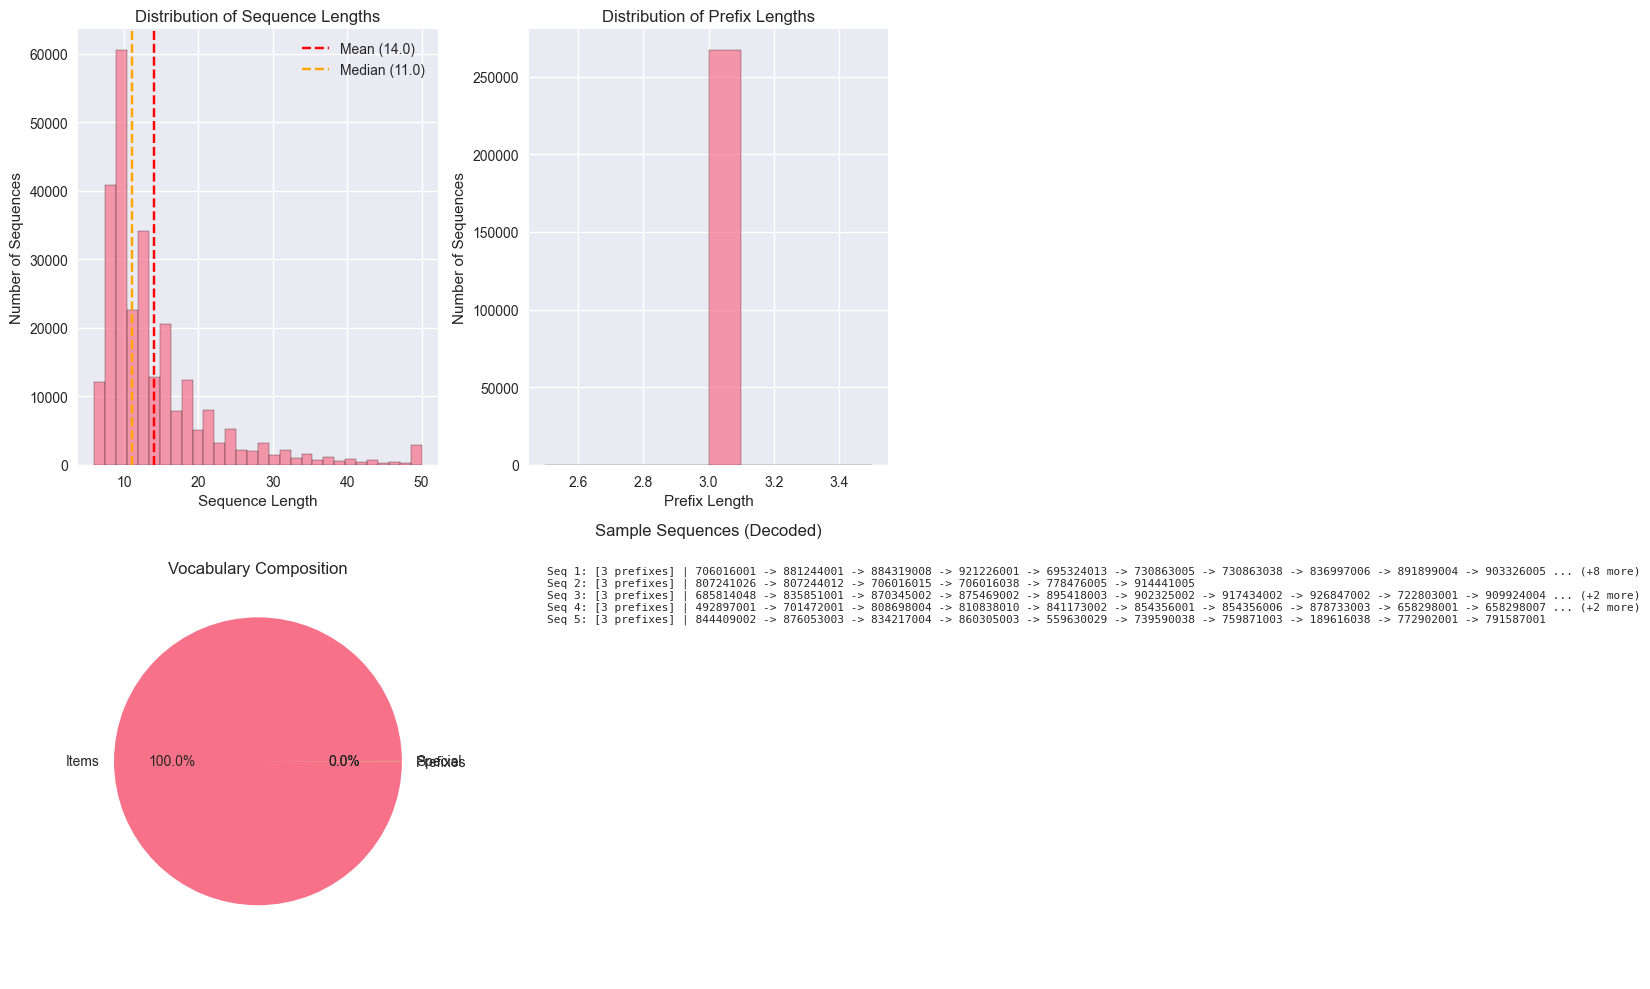

📊 Sequence analysis complete!


In [6]:
# Visualise sequence characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sequence length distribution
axes[0,0].hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black')
axes[0,0].axvline(np.mean(seq_lengths), color='red', linestyle='--', label=f'Mean ({np.mean(seq_lengths):.1f})')
axes[0,0].axvline(np.median(seq_lengths), color='orange', linestyle='--', label=f'Median ({np.median(seq_lengths):.1f})')
axes[0,0].set_xlabel('Sequence Length')
axes[0,0].set_ylabel('Number of Sequences')
axes[0,0].set_title('Distribution of Sequence Lengths')
axes[0,0].legend()

# Prefix length distribution
axes[0,1].hist(prepared_data.prefix_lengths, bins=10, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Prefix Length')
axes[0,1].set_ylabel('Number of Sequences')
axes[0,1].set_title('Distribution of Prefix Lengths')

# Vocabulary composition
vocab_breakdown = {
    'Items': len(prepared_data.registry.item2id),
    'Prefixes': len(prepared_data.registry.prefix_token2id),
    'Special': 2  # PAD, MASK
}

axes[1,0].pie(vocab_breakdown.values(), labels=vocab_breakdown.keys(), autopct='%1.1f%%')
axes[1,0].set_title('Vocabulary Composition')

# Sample sequence visualization (decode first few sequences)
sample_sequences = prepared_data.sequences[:5]
sample_info = []

for i, seq in enumerate(sample_sequences):
    prefix_len = prepared_data.prefix_lengths[i]
    prefixes = seq[:prefix_len]
    items = seq[prefix_len:]
    
    # Decode prefixes (simplified)
    prefix_str = f"[{prefix_len} prefixes]"
    
    # Decode items
    decoded_items = []
    for token_id in items[:10]:  # Show first 10 items
        article_id = prepared_data.registry.decode_item(token_id)
        if article_id is not None:
            decoded_items.append(str(article_id))
    
    items_str = ' -> '.join(decoded_items)
    if len(items) > 10:
        items_str += f" ... (+{len(items)-10} more)"
    
    sample_info.append(f"Seq {i+1}: {prefix_str} | {items_str}")

# Display sample sequences
axes[1,1].text(0.05, 0.95, '\n'.join(sample_info), transform=axes[1,1].transAxes, 
               fontsize=8, verticalalignment='top', fontfamily='monospace')
axes[1,1].set_title('Sample Sequences (Decoded)')
axes[1,1].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'sequence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Sequence analysis complete!")

## 5. Create DataLoaders


In [7]:
# Create data loaders
print("🔄 Creating data loaders...")

# Masking configuration
masking_options = MaskingOptions(
    mask_prob=0.15,           # 15% of tokens to predict
    random_token_prob=0.10,   # 10% random replacements
    keep_original_prob=0.10   # 10% keep original
)

# Build data loaders
batch_size = 64  # Start with smaller batch size for testing
valid_split = 0.1
num_workers = 0  # Set to 0 for debugging, increase for faster loading

train_loader, valid_loader, eval_loader = build_dataloaders_for_bert4rec(
    prepared=prepared_data,
    batch_size=batch_size,
    masking=masking_options,
    valid_split=valid_split,
    num_workers=num_workers
)

print(f"✅ Data loaders created!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Evaluation batches: {len(eval_loader)}")
print(f"Batch size: {batch_size}")

# Test a batch
print("\n🔍 Testing data loader...")
sample_batch = next(iter(train_loader))
print(f"Batch keys: {list(sample_batch.keys())}")
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Labels shape: {sample_batch['labels'].shape}")
print(f"Attention mask shape: {sample_batch['attention_mask'].shape}")

# Check masking
input_ids = sample_batch['input_ids'][0]  # First sequence
labels = sample_batch['labels'][0]
attention_mask = sample_batch['attention_mask'][0]

print(f"\nSample sequence analysis:")
print(f"Non-padded length: {attention_mask.sum().item()}")
print(f"Masked positions: {(labels != -100).sum().item()}")
print(f"MASK tokens: {(input_ids == 1).sum().item()}")

🔄 Creating data loaders...


Splitting sequences:   0%|          | 0/267027 [00:00<?, ?it/s]

✅ Data loaders created!
Training batches: 3756
Validation batches: 418
Evaluation batches: 4173
Batch size: 64

🔍 Testing data loader...
Batch keys: ['input_ids', 'labels', 'attention_mask']
Input IDs shape: torch.Size([64, 50])
Labels shape: torch.Size([64, 50])
Attention mask shape: torch.Size([64, 50])

Sample sequence analysis:
Non-padded length: 18
Masked positions: 2
MASK tokens: 2


## 6. Initialise and Train Model


In [8]:
# Model configuration
print("🤖 Initialising BERT4Rec model...")

model_config = {
    'vocab_size': prepared_data.registry.vocab_size,
    'd_model': 128,           # Smaller for initial testing
    'n_heads': 4,
    'n_layers': 2,            # Fewer layers for faster training
    'dim_feedforward': 256,
    'max_len': sequence_options.max_len,
    'dropout': 0.1
}

model = BERT4RecModel(**model_config)
model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Model configuration: {model_config}")

# Training configuration
train_config = TrainConfig(
    batch_size=batch_size,
    lr=1e-3,
    weight_decay=1e-4,
    n_epochs=6,               # Fewer epochs for initial testing
    warmup_steps=100,
    grad_clip_norm=1.0
)

print(f"Training configuration:")
print(f"  Epochs: {train_config.n_epochs}")
print(f"  Learning rate: {train_config.lr}")
print(f"  Batch size: {train_config.batch_size}")
print(f"  Warmup steps: {train_config.warmup_steps}")

🤖 Initialising BERT4Rec model...
Model created with 5,572,226 parameters
Model configuration: {'vocab_size': 41090, 'd_model': 128, 'n_heads': 4, 'n_layers': 2, 'dim_feedforward': 256, 'max_len': 50, 'dropout': 0.1}
Training configuration:
  Epochs: 6
  Learning rate: 0.001
  Batch size: 64
  Warmup steps: 100


In [9]:
# Train the model
print("🚀 Starting model training...")
print(f"Training on device: {device}")

start_time = time.time()

train_bert4rec(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    cfg=train_config,
    device=device
)

training_time = time.time() - start_time
print(f"\n✅ Training completed in {training_time/60:.1f} minutes!")

# Save trained model
model_save_path = RESULTS_ROOT / 'bert4rec_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'train_config': train_config,
    'vocab_size': prepared_data.registry.vocab_size,
    'sequence_options': sequence_options
}, model_save_path)

print(f"Model saved to: {model_save_path}")

🚀 Starting model training...
Training on device: cpu


Training epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/6:   0%|          | 0/3756 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/418 [00:00<?, ?it/s]

Epoch 1/6 - training loss: 8.7730 | validation loss: 7.9425


Epoch 2/6:   0%|          | 0/3756 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/418 [00:00<?, ?it/s]

Epoch 2/6 - training loss: 7.5351 | validation loss: 7.2119


Epoch 3/6:   0%|          | 0/3756 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/418 [00:00<?, ?it/s]

Epoch 3/6 - training loss: 7.0362 | validation loss: 6.9189


Epoch 4/6:   0%|          | 0/3756 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/418 [00:00<?, ?it/s]

Epoch 4/6 - training loss: 6.7767 | validation loss: 6.7391


Epoch 5/6:   0%|          | 0/3756 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/418 [00:00<?, ?it/s]

Epoch 5/6 - training loss: 6.5975 | validation loss: 6.6457


Epoch 6/6:   0%|          | 0/3756 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/418 [00:00<?, ?it/s]

Epoch 6/6 - training loss: 6.4699 | validation loss: 6.6024

✅ Training completed in 142.8 minutes!
Model saved to: ../../results/modelling/bert4rec_model.pt


## 7. Model Evaluation


In [10]:
# Evaluate model performance
print("📊 Evaluating model performance...")

# Evaluate on different top-K values
topk_values = [5, 10, 20, 50]
evaluation_results = {}

for k in topk_values:
    print(f"\nEvaluating Recall@{k} and NDCG@{k}...")
    start_time = time.time()
    
    recall_k, ndcg_k = evaluate_next_item_topk(
        model=model,
        loader=eval_loader,
        device=device,
        registry=prepared_data.registry,
        topk=k
    )
    
    eval_time = time.time() - start_time
    
    evaluation_results[k] = {
        'recall': recall_k,
        'ndcg': ndcg_k,
        'eval_time': eval_time
    }
    
    print(f"Recall@{k}: {recall_k:.4f}")
    print(f"NDCG@{k}: {ndcg_k:.4f}")
    print(f"Evaluation time: {eval_time:.2f} seconds")

print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)

for k in topk_values:
    results = evaluation_results[k]
    print(f"Top-{k:2d}: Recall={results['recall']:.4f}, NDCG={results['ndcg']:.4f}")

print("="*50)

📊 Evaluating model performance...

Evaluating Recall@5 and NDCG@5...


Evaluating next-item:   0%|          | 0/4173 [00:00<?, ?it/s]

Recall@5: 0.1564
NDCG@5: 0.1111
Evaluation time: 472.74 seconds

Evaluating Recall@10 and NDCG@10...


Evaluating next-item:   0%|          | 0/4173 [00:00<?, ?it/s]

Recall@10: 0.2081
NDCG@10: 0.1278
Evaluation time: 479.13 seconds

Evaluating Recall@20 and NDCG@20...


Evaluating next-item:   0%|          | 0/4173 [00:00<?, ?it/s]

Recall@20: 0.2673
NDCG@20: 0.1427
Evaluation time: 462.99 seconds

Evaluating Recall@50 and NDCG@50...


Evaluating next-item:   0%|          | 0/4173 [00:00<?, ?it/s]

Recall@50: 0.3597
NDCG@50: 0.1610
Evaluation time: 464.98 seconds

FINAL EVALUATION RESULTS
Top- 5: Recall=0.1564, NDCG=0.1111
Top-10: Recall=0.2081, NDCG=0.1278
Top-20: Recall=0.2673, NDCG=0.1427
Top-50: Recall=0.3597, NDCG=0.1610


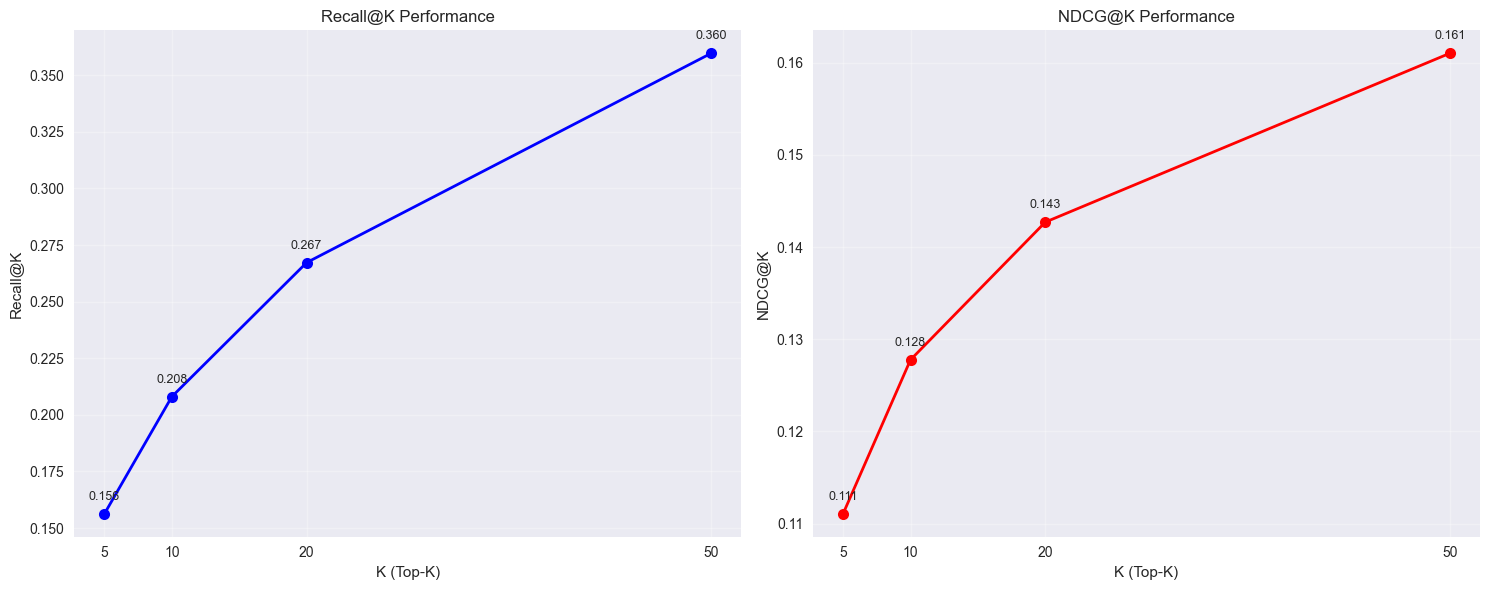

📊 Evaluation visualisation complete!


In [ ]:
# Visualise evaluation results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Recall@K plot
recall_values = [evaluation_results[k]['recall'] for k in topk_values]
axes[0].plot(topk_values, recall_values, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('K (Top-K)')
axes[0].set_ylabel('Recall@K')
axes[0].set_title('Recall@K Performance')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(topk_values)

# Add value labels on points
for k, recall in zip(topk_values, recall_values):
    axes[0].annotate(f'{recall:.3f}', (k, recall), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

# NDCG@K plot
ndcg_values = [evaluation_results[k]['ndcg'] for k in topk_values]
axes[1].plot(topk_values, ndcg_values, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('K (Top-K)')
axes[1].set_ylabel('NDCG@K')
axes[1].set_title('NDCG@K Performance')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(topk_values)

# Add value labels on points
for k, ndcg in zip(topk_values, ndcg_values):
    axes[1].annotate(f'{ndcg:.3f}', (k, ndcg), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'bert4rec_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Evaluation visualisation complete!")

## 8. Model Analysis and Insights


In [12]:
# Analyze model performance by customer segment
print("🔍 Analyzing performance by customer segment...")

# Get customer segments for evaluation data
# Note: This is a simplified analysis - in practice you'd need to track which customers are in eval set
segment_counts = customers['customer_cluster'].value_counts().sort('customer_cluster')
print("Customer segment distribution:")
for row in segment_counts.iter_rows():
    cluster, count = row
    percentage = count / len(customers) * 100
    print(f"  Segment {cluster}: {count:,} customers ({percentage:.1f}%)")

# Analyze vocabulary usage
print("\n🔍 Analyzing vocabulary composition...")
print(f"Total vocabulary size: {prepared_data.registry.vocab_size:,}")
print(f"Article tokens: {len(prepared_data.registry.item2id):,}")
print(f"Prefix tokens: {len(prepared_data.registry.prefix_token2id):,}")
print(f"Special tokens: 2 (PAD, MASK)")

# Show prefix token breakdown
if prepared_data.registry.prefix_token2id:
    print("\nPrefix tokens by type:")
    prefix_types = {}
    for token in prepared_data.registry.prefix_token2id.keys():
        prefix_type = token.split('=')[0]
        prefix_types[prefix_type] = prefix_types.get(prefix_type, 0) + 1
    
    for prefix_type, count in prefix_types.items():
        print(f"  {prefix_type}: {count} tokens")

print("\n✅ Model analysis complete!")

🔍 Analyzing performance by customer segment...
Customer segment distribution:
  Segment 0: 34,144 customers (6.5%)
  Segment 1: 89,013 customers (17.0%)
  Segment 2: 199,275 customers (38.0%)
  Segment 3: 147,822 customers (28.2%)
  Segment 4: 54,821 customers (10.4%)

🔍 Analyzing vocabulary composition...
Total vocabulary size: 41,090
Article tokens: 41,071
Prefix tokens: 17
Special tokens: 2 (PAD, MASK)

Prefix tokens by type:
  SEG: 5 tokens
  CH: 2 tokens
  PB: 10 tokens

✅ Model analysis complete!


In [13]:
# Generate sample predictions for interpretation
print("🎯 Generating sample predictions...")

model.eval()
with torch.no_grad():
    # Get a few sample sequences from evaluation set
    sample_batch = next(iter(eval_loader))
    input_ids = sample_batch['input_ids'][:5].to(device)  # First 5 sequences
    attention_mask = sample_batch['attention_mask'][:5].to(device)
    labels = sample_batch['labels'][:5].to(device)
    
    # Get model predictions
    logits = model(input_ids, attention_mask)  # Shape: (5, seq_len, vocab_size)
    
    print("Sample prediction analysis:")
    for i in range(5):
        # Find the masked position
        mask_positions = (labels[i] != -100).nonzero(as_tuple=False).squeeze(-1)
        if len(mask_positions) > 0:
            mask_pos = int(mask_positions[0].item())
            true_item = int(labels[i, mask_pos].item())
            
            # Get top predictions
            pred_scores = logits[i, mask_pos]  # Scores for masked position
            top_scores, top_items = torch.topk(pred_scores, k=10)
            
            # Decode true item
            true_article = prepared_data.registry.decode_item(true_item)
            
            print(f"\nSequence {i+1}:")
            print(f"  True next item: {true_article}")
            print(f"  Top 5 predictions:")
            
            for j in range(5):
                pred_item_id = int(top_items[j].item())
                pred_article = prepared_data.registry.decode_item(pred_item_id)
                score = float(top_scores[j].item())
                is_correct = "✓" if pred_item_id == true_item else " "
                print(f"    {j+1}. {pred_article} (score: {score:.2f}) {is_correct}")

print("\n🎯 Sample predictions complete!")

🎯 Generating sample predictions...
Sample prediction analysis:

Sequence 1:
  True next item: 921226007
  Top 5 predictions:
    1. 914441005 (score: 12.15)  
    2. 931769003 (score: 12.05)  
    3. 923643001 (score: 11.69)  
    4. 931769001 (score: 11.00)  
    5. 914441004 (score: 11.00)  

Sequence 2:
  True next item: 914441005
  Top 5 predictions:
    1. 914441004 (score: 6.31)  
    2. 914441001 (score: 6.11)  
    3. 914441003 (score: 6.06)  
    4. 762846031 (score: 5.59)  
    5. 914441005 (score: 5.49) ✓

Sequence 3:
  True next item: 946748003
  Top 5 predictions:
    1. 917434004 (score: 9.08)  
    2. 917434002 (score: 8.36)  
    3. 941005005 (score: 7.85)  
    4. 917434003 (score: 7.66)  
    5. 941005003 (score: 7.44)  

Sequence 4:
  True next item: 843373003
  Top 5 predictions:
    1. 843373003 (score: 7.49) ✓
    2. 843373001 (score: 7.41)  
    3. 881823004 (score: 6.20)  
    4. 863665004 (score: 6.02)  
    5. 872002001 (score: 5.93)  

Sequence 5:
  True next

## 9. Summary and Recommendations


In [14]:
# Generate comprehensive summary
print("📋 BERT4Rec Model Training Summary")
print("="*60)

print("\n📊 Dataset Statistics:")
print(f"  Total customers: {n_customers:,}")
print(f"  Active customers (≥{min_transactions} txns): {len(active_customers):,}")
print(f"  Total articles: {n_articles:,}")
print(f"  Total transactions: {n_transactions:,}")
print(f"  Training sequences: {len(prepared_data.sequences):,}")

print("\n🏗️ Model Configuration:")
print(f"  Vocabulary size: {model_config['vocab_size']:,}")
print(f"  Hidden dimensions: {model_config['d_model']}")
print(f"  Attention heads: {model_config['n_heads']}")
print(f"  Transformer layers: {model_config['n_layers']}")
print(f"  Max sequence length: {model_config['max_len']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n🎯 Training Configuration:")
print(f"  Epochs: {train_config.n_epochs}")
print(f"  Batch size: {train_config.batch_size}")
print(f"  Learning rate: {train_config.lr}")
print(f"  Training time: {training_time/60:.1f} minutes")

print("\n📈 Performance Results:")
for k in topk_values:
    results = evaluation_results[k]
    print(f"  Recall@{k:2d}: {results['recall']:.4f} | NDCG@{k:2d}: {results['ndcg']:.4f}")

print("\n💡 Key Insights:")
best_k = max(topk_values, key=lambda k: evaluation_results[k]['recall'])
best_recall = evaluation_results[best_k]['recall']
print(f"  • Best performance at Top-{best_k} with {best_recall:.1%} recall")
print(f"  • Model successfully learns from {len(prepared_data.sequences):,} customer sequences")
print(f"  • Prefix tokens provide customer context (segment, channel, price)")
print(f"  • Average sequence length: {np.mean(seq_lengths):.1f} items")

print("\n🚀 Next Steps & Recommendations:")
print("  1. Increase model capacity (more layers, larger hidden size)")
print("  2. Train for more epochs with learning rate scheduling")
print("  3. Experiment with different sequence lengths and masking strategies")
print("  4. Add more sophisticated features (seasonal, product attributes)")
print("  5. Implement ensemble with other recommendation approaches")
print("  6. A/B test against collaborative filtering baseline")
print("  7. Analyze performance across different customer segments")
print("  8. Optimize for production deployment (model distillation, caching)")

print("\n" + "="*60)
print("✅ BERT4Rec experiment completed successfully!")
print(f"📁 Results saved to: {RESULTS_ROOT}")
print("="*60)

📋 BERT4Rec Model Training Summary

📊 Dataset Statistics:
  Total customers: 525,075
  Active customers (≥5 txns): 268,057
  Total articles: 42,298
  Total transactions: 3,904,391
  Training sequences: 267,027

🏗️ Model Configuration:
  Vocabulary size: 41,090
  Hidden dimensions: 128
  Attention heads: 4
  Transformer layers: 2
  Max sequence length: 50
  Total parameters: 5,572,226

🎯 Training Configuration:
  Epochs: 6
  Batch size: 64
  Learning rate: 0.001
  Training time: 142.8 minutes

📈 Performance Results:
  Recall@ 5: 0.1564 | NDCG@ 5: 0.1111
  Recall@10: 0.2081 | NDCG@10: 0.1278
  Recall@20: 0.2673 | NDCG@20: 0.1427
  Recall@50: 0.3597 | NDCG@50: 0.1610

💡 Key Insights:
  • Best performance at Top-50 with 36.0% recall
  • Model successfully learns from 267,027 customer sequences
  • Prefix tokens provide customer context (segment, channel, price)
  • Average sequence length: 14.0 items

🚀 Next Steps & Recommendations:
  1. Increase model capacity (more layers, larger hidden s

In [15]:
# Save experiment results
import json

experiment_results = {
    'timestamp': datetime.now().isoformat(),
    'dataset_stats': {
        'total_customers': n_customers,
        'active_customers': len(active_customers),
        'total_articles': n_articles,
        'total_transactions': n_transactions,
        'training_sequences': len(prepared_data.sequences)
    },
    'model_config': model_config,
    'train_config': {
        'batch_size': train_config.batch_size,
        'lr': train_config.lr,
        'weight_decay': train_config.weight_decay,
        'n_epochs': train_config.n_epochs,
        'warmup_steps': train_config.warmup_steps
    },
    'sequence_config': {
        'max_len': sequence_options.max_len,
        'min_len': sequence_options.min_len,
        'add_segment_prefix': sequence_options.add_segment_prefix,
        'add_channel_prefix': sequence_options.add_channel_prefix,
        'add_priceband_prefix': sequence_options.add_priceband_prefix
    },
    'performance': {
        f'recall_at_{k}': evaluation_results[k]['recall'] for k in topk_values
    } | {
        f'ndcg_at_{k}': evaluation_results[k]['ndcg'] for k in topk_values
    },
    'training_time_minutes': training_time / 60,
    'vocab_size': prepared_data.registry.vocab_size,
    'avg_sequence_length': float(np.mean(seq_lengths))
}

# Save results
results_file = RESULTS_ROOT / 'bert4rec_experiment_results.json'
with open(results_file, 'w') as f:
    json.dump(experiment_results, f, indent=2)

print(f"📁 Experiment results saved to: {results_file}")
print("\n🎉 Notebook execution complete!")

📁 Experiment results saved to: ../../results/modelling/bert4rec_experiment_results.json

🎉 Notebook execution complete!
